In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys, time
import pandas as pd
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry'],
      dtype='object')

In [3]:
# load and prepare our study region for cropping TreeMap
# Southern Rockies ecoregion bounds (buffered)
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_srme.gpkg')
srm = gpd.read_file(fp)
# Crop the raster by the SRM bounds
srm['geometry'] = srm.geometry.buffer(10000)
bounds = srm.total_bounds # total bounds of ecoregion
bounds

array([-1193290.29502988,  1391628.00599962,  -683136.18714099,
        2253336.36986925])

In [4]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
treemap_da = treemap_da.sel(band=1) # the "tm_id" band, dropping the FORTYP band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = treemap_da.shape, treemap_da.spatial_ref.GeoTransform, treemap_da.rio.crs, treemap_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {treemap_da[0].dtype}")

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


In [5]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(treemap_da), 1, 0)

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"Saved multi-band raster to: {out_fp}")

# calculate the total grid pixels
# see __functions.py 'compute_band_stats'
forest_pct = compute_band_stats(grid, forest_mask, 'grid_index', attr='constant')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pix'
}, inplace=True)
forest_pct = forest_pct[forest_pct['constant'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_index','forest_pix','forest_pct']]

n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")

print(f"\n{forest_pct.head(3)}")

del forest_mask
gc.collect() # clean up

Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif
[84.76%] predominantly forest grids.

   grid_index  forest_pix  forest_pct
0     1955419         169       100.0
1     1955420         182       100.0
2     1955421         169       100.0


16

In [6]:
# get the count/proportion of unique "tm_id" from TreeMap in grids

t0 = time.time()

# see __functions.py
grid_tmid = compute_band_stats(grid, treemap_da, 'grid_index', attr='tm_id')

# tidy columns in the summary table
grid_tmid['count'] = grid_tmid['count'].astype(int)
grid_tmid['total_pixels'] = grid_tmid['total_pixels'].astype(int)
grid_tmid.rename(columns={
    'count': 'tmid_count',
    'total_pixels': 'total_pix',
    'pct_cover': 'tmid_pct' # percent of forest area
}, inplace=True)

# join in the forest_pct
grid_tmid = grid_tmid.merge(forest_pct, on='grid_index', how='left')
print(f"\n{grid_tmid.head(10)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del treemap_da # clean up 
gc.collect()


   grid_index  tm_id  tmid_count  total_pix   tmid_pct  forest_pix  forest_pct
0     1955419   5081           2        169   1.183432         169       100.0
1     1955419   5490          44        169  26.035503         169       100.0
2     1955419   5501           2        169   1.183432         169       100.0
3     1955419  12665           3        169   1.775148         169       100.0
4     1955419  20313           5        169   2.958580         169       100.0
5     1955419  45478           8        169   4.733728         169       100.0
6     1955419  46099           1        169   0.591716         169       100.0
7     1955419  51905           5        169   2.958580         169       100.0
8     1955419  53570           3        169   1.775148         169       100.0
9     1955419  53601           1        169   0.591716         169       100.0

Total elapsed time: 0.68 minutes.

~~~~~~~~~~



44

In [7]:
# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# join the Tree Table to the grid data
grid_trees = grid_tmid.merge(tree_tbl, on='tm_id', how='left')
print(f"\n{grid_trees.head(3)}")

del tree_tbl # clean up
gc.collect()

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')

   grid_index  tm_id  tmid_count  total_pix  tmid_pct  forest_pix  forest_pct  \
0     1955419   5081           2        169  1.183432         169       100.0   
1     1955419   5081           2        169  1.183432         169       100.0   
2     1955419   5081           2        169  1.183432         169       100.0   

             CN  STATUSCD  TPA_UNADJ  ...        COMMON_NAME  \
0  3.536933e+13       1.0   6.018046  ...  Arizona white oak   
1  3.536933e+13       1.0   6.018046  ...  Arizona white oak   
2  3.536933e+13       2.0   6.018046  ...  Arizona white oak   

     SCIENTIFIC_NAME SPECIES_SYMBOL   DIA    HT  ACTUALHT    CR  SUBP  TREE  \
0  Quercus arizonica           QUAR  10.9  15.0      15.0  70.0   1.0   1.0   
1  Quercus arizonica           QUAR   5.6  11.0      11.0

0

In [8]:
# Calculate the Shannon diversity index for each tm_id
# Using the full list of trees in the Tree Table
# Based on total trees per tm_id and proportion
grid_trees['total_trees'] = grid_trees.groupby('tm_id')['TREE'].transform('sum')
grid_trees['p_species'] = grid_trees['TREE'] / grid_trees['total_trees'] # proportion

# Calculate Shannon diversity (H') for each tree row
grid_trees['shannon_h'] = -grid_trees['p_species'] * np.log(grid_trees['p_species'])

# Aggregate to calculate H' at the tm_id level
shannon_tmid = (
    grid_trees.groupby('tm_id', as_index=False)
    .agg(shannon_h=('shannon_h', 'sum')))
# subset columns
shannon_tmid = shannon_tmid[['tm_id','shannon_h']]
print(shannon_tmid.head(3))

# merge back to the grid data
grid_trees.drop(columns=['shannon_h', 'total_trees', 'p_species'], inplace=True)
grid_trees = grid_trees.merge(shannon_tmid, on='tm_id', how='left')
print(f"\n{grid_trees.columns}")

del shannon_tmid
gc.collect()

   tm_id  shannon_h
0     32   5.706651
1    845   4.065466
2   1207   5.954289

Index(['grid_index', 'tm_id', 'tmid_count', 'total_pix', 'tmid_pct',
       'forest_pix', 'forest_pct', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD',
       'COMMON_NAME', 'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT',
       'ACTUALHT', 'CR', 'SUBP', 'TREE', 'AGENTCD', 'shannon_h'],
      dtype='object')


0

In [9]:
# Calculate the Tree Table statistics across tm_id/grid_index combinations
#### Abundance (trees/acre, scaled to per-pixel)
#### Dominance (live basal area, scaled to per-pixel)
#### Tree height (average/species)

# force species name to lower case
grid_trees.rename(columns={'COMMON_NAME': 'species'}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
# tidy the live/dead column
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)
# calculate the trees per acre, scaling by the acre/pixel factor
grid_trees['tree_tpa'] = (grid_trees['TREE'] * grid_trees['TPA_UNADJ']) * 0.222395 # trees/acre

# calculate live basal area (balive) scaled by TPA
grid_trees['BA'] = np.pi * (grid_trees['DIA'] / 2) ** 2  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['tree_tpa']  # adjust based on tree abundance

# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead seperately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        tmid_pixels=('tmid_count','max'), # retains the tm_id pixel count
        tmid_pct=('tmid_pct','max'), # retain the percent of forested area
        forest_pct=('forest_pct','max'), # retain forest percent for the grid
        shannon_h=('shannon_h','max'), # retains the tm_id shannon index
        balive=('BA_TPAsc', 'sum'),    # total BALIVE
        tpa_live=('tree_tpa', 'sum'),  # total live tree count (trees/acre)
        tree_ht_live=('ACTUALHT','mean') # average tree height
    )
)

# dead trees
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        badead=('BA_TPAsc', 'sum'),    # Live basal area
        tpa_dead=('tree_tpa', 'sum'),  # Total live tree count (trees/acre)
        tree_ht_dead=('ACTUALHT','mean') # average tree height
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics, 
    on=['grid_index', 'tm_id', 'species'], 
    how='outer'
).fillna(0)
# total acres for the tm_id (pixels * conversion factor)
tree_metrics['tmid_acres'] =  tree_metrics['tmid_pixels'] * 0.222395 
# subset to the tree metric columns
tree_metrics = tree_metrics[['grid_index','tm_id','tmid_pixels','tmid_acres',
                             'tmid_pct','forest_pct','species','shannon_h',
                             'balive','badead','tpa_live','tpa_dead',
                             'tree_ht_live','tree_ht_dead']]

# Add a "combined TPA" (live + dead)
# this may be important for lodgepole and spruce-fir in particular (beetle-kill)
tree_metrics['tpa_ld'] = tree_metrics['tpa_live'] + tree_metrics['tpa_dead']
tree_metrics['ba_ld'] = tree_metrics['balive'] + tree_metrics['badead']

print(f"\n{tree_metrics.head(12)}")
del live_metrics, dead_metrics
gc.collect()


    grid_index  tm_id  tmid_pixels  tmid_acres   tmid_pct  forest_pct  \
0       183297   5447          7.0    1.556765   6.140351   67.455621   
1       183297   5447          7.0    1.556765   6.140351   67.455621   
2       183297  13033         45.0   10.007775  39.473684   67.455621   
3       183297  13033         45.0   10.007775  39.473684   67.455621   
4       183297  41520         11.0    2.446345   9.649123   67.455621   
5       183297  41609          5.0    1.111975   4.385965   67.455621   
6       183297  46609         39.0    8.673405  34.210526   67.455621   
7       183297  46609         39.0    8.673405  34.210526   67.455621   
8       183298  13198          1.0    0.222395   1.234568   44.505495   
9       183298  46609         65.0   14.455675  80.246914   44.505495   
10      183298  46609         65.0   14.455675  80.246914   44.505495   
11      183299   4505          2.0    0.444790   4.255319   27.810651   

                        species  shannon_h       

0

In [10]:
unique_spp = tree_metrics['species'].unique()
unique_spp

array(['common or two-needle pinyon', 'utah juniper', 'oneseed juniper',
       'velvet mesquite', 'honey mesquite', 'siberian elm', 'gambel oak',
       'alligator juniper', 'arizona pinyon pine', 'singleleaf pinyon',
       'ponderosa pine', 'western juniper', 'arizona white oak',
       'cherrybark oak', 'common persimmon', 'eastern hophornbeam',
       'eastern redbud', 'green ash', 'shagbark hickory', 'sugarberry',
       'swamp chestnut oak', 'sweetgum', 'emory oak',
       'mexican pinyon pine', 'blue spruce', 'douglas-fir',
       'quaking aspen', 'white fir', 'american hornbeam, musclewood',
       'red maple', 'river birch', 'swamp tupelo', 'sweetbay',
       'water oak', 'water tupelo', 'narrowleaf cottonwood',
       'plains cottonwood', 'rocky mountain juniper',
       'eastern cottonwood', 'fremont cottonwood',
       'southwestern white pine', 'jeffrey pine', 'loblolly pine',
       'pignut hickory', 'post oak', 'sassafras', 'southern red oak',
       'white oak', 'ameri

In [11]:
[s for s in unique_spp if 'pine' in str(s).lower()] # check pine species

['arizona pinyon pine',
 'ponderosa pine',
 'mexican pinyon pine',
 'southwestern white pine',
 'jeffrey pine',
 'loblolly pine',
 'longleaf pine',
 'slash pine',
 'arizona pine',
 'sugar pine',
 'knobcone pine',
 'lodgepole pine',
 'washoe pine',
 'subalpine fir',
 'whitebark pine',
 'gray or california foothill pine',
 'limber pine',
 'great basin bristlecone pine',
 'western white pine',
 'rocky mountain bristlecone pine',
 'jack pine',
 'eastern white pine',
 'sand pine',
 'shortleaf pine',
 'chihuahuan pine',
 'virginia pine',
 'spruce pine',
 'pond pine',
 'red pine']

In [12]:
# Identify the primary species from the Tree Table
# identify the species which make up 97% of landscape
spp_pr = (
    tree_metrics.groupby('species', as_index=False)
    .agg(
        balive=('balive', 'sum'),
        ba_ld=('ba_ld', 'sum'),
        tpa_live=('tpa_live', 'sum'),
        tpa_ld=('tpa_ld', 'sum') # live+dead
    )
)
# calculate the fractions for both BALIVE and TPA
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['ba_ld_f'] = spp_pr['ba_ld'] / spp_pr['ba_ld'].sum() # live+dead
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
spp_pr['tpa_ld_f'] = spp_pr['tpa_ld'] / spp_pr['tpa_ld'].sum() # live+dead
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='ba_ld_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['ba_ld_f_csum'] = spp_pr['ba_ld_f'].cumsum() # live+dead
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
spp_pr['tpa_ld_f_csum'] = spp_pr['tpa_ld_f'].cumsum() # live+dead

metric = 'ba_ld_f_csum'
top_species = spp_pr[spp_pr[metric] <= 0.99]
print(f"\nSpecies making up 97% of *{metric}*: \n\n{top_species[['species','ba_ld','tpa_ld']]}\n\n")


Species making up 97% of *ba_ld_f_csum*: 

                          species         ba_ld        tpa_ld
134                ponderosa pine  8.499388e+10  1.532846e+09
100                lodgepole pine  4.158066e+10  2.610325e+09
80                      grand fir  2.594398e+10  5.952783e+08
64                    douglas-fir  1.786395e+10  4.292833e+08
203                     white fir  1.048952e+10  3.140411e+08
93                   jeffrey pine  1.027366e+10  1.386313e+08
173                 subalpine fir  8.368008e+09  5.478531e+08
198               western juniper  7.852138e+09  1.212141e+08
74               engelmann spruce  6.138088e+09  2.918200e+08
137                 quaking aspen  3.315437e+09  1.616115e+08
199                 western larch  3.314474e+09  1.001725e+08
90                  incense-cedar  3.048827e+09  4.657282e+07
62     curlleaf mountain-mahogany  2.462039e+09  5.320397e+07
78                     gambel oak  1.289538e+09  2.520150e+08
188                  utah 

In [13]:
# Assess the species co-occurrence matrix to look for natural groupings
# Tests the "commonness" of species pairings
# Particularly, what to do with the "mixed conifers"
from itertools import combinations
from collections import Counter

# 1. Filter Tree Table to relevant species (most common)
spp_filter = ['white fir', 'grand fir', 'douglas-fir', 'engelmann spruce', 'subalpine fir', 'western larch']
# spp_filter = ['gambel oak', 'incense-cedar', 'canyon live oak', 'california black oak', 
#               'curlleaf mountain-mahogany', 'western juniper', 'singleleaf pinyon',
#               'common or two-needle pinyon', 'utah juniper'
#              ]
top_spp_df = tree_metrics[tree_metrics['species'].str.lower().isin(spp_filter)]
# 2. Group species by tm_id
spp_tmid = (
    top_spp_df.groupby('tm_id')['species']
    .apply(lambda x: list(x.str.lower().unique()))  # Get unique species per tm_id
    .reset_index()
)
# 3. Generate all pairwise species combinations per tm_id
species_pairs = spp_tmid['species'].apply(
    lambda species_list: list(combinations(sorted(species_list), 2))
)
# Flatten list of all pairs
all_pairs = [pair for sublist in species_pairs for pair in sublist]
# 4. Count co-occurrences of each pair
pair_counts = Counter(all_pairs)
# Convert to DataFrame
pair_counts_df = (
    pd.DataFrame(pair_counts.items(), columns=['species_pair', 'coo_count'])
    .sort_values(by='coo_count', ascending=False)
)
# 5. Calculate co-occurrence percentage
total_tmid = len(spp_tmid)
pair_counts_df['coo_pct'] = pair_counts_df['coo_count'] / total_tmid * 100

# Inspect results
print(f"\n{pair_counts_df.head(30)}")


                         species_pair  coo_count    coo_pct
4   (engelmann spruce, subalpine fir)        649  23.087869
0     (douglas-fir, engelmann spruce)        333  11.846318
6            (douglas-fir, grand fir)        333  11.846318
1            (douglas-fir, white fir)        324  11.526147
3        (douglas-fir, subalpine fir)        265   9.427250
10       (douglas-fir, western larch)        217   7.719673
11         (grand fir, western larch)        157   5.585201
2       (engelmann spruce, white fir)         74   2.632515
8   (engelmann spruce, western larch)         69   2.454642
12      (engelmann spruce, grand fir)         61   2.170046
9      (subalpine fir, western larch)         60   2.134472
7          (grand fir, subalpine fir)         38   1.351832
14             (grand fir, white fir)         22   0.782640
13         (western larch, white fir)         19   0.675916
5          (subalpine fir, white fir)         16   0.569192


In [14]:
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'pinyon|juniper': 'pinon-juniper',
    'engelmann spruce|subalpine fir|corkbark fir': 'spruce-fir',
    'limber|bristlecone|whitebark': 'subalpine-pine',
    'ponderosa pine|Jeffrey': 'ponderosa', 
    'lodgepole pine': 'lodgepole',
    'aspen': 'quaking aspen',
    'douglas-fir|grand fir|white fir|larch': 'mixed-conifer',
    'oak': 'oak-woodland',
    'cottonwood|willow': 'woody-riparian'
}

spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = tree_metrics[tree_metrics['species'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['species'].unique()})

# Apply the remap to create a new grouped species column
tree_metrics['species_gp_n'] = tree_metrics['species'].map(spp_remap).fillna(tree_metrics['species'])
# Verify the updated species groups
print(tree_metrics[['species', 'species_gp_n']].drop_duplicates().head(10))

                        species     species_gp_n
0   common or two-needle pinyon    pinon-juniper
1                  utah juniper    pinon-juniper
7               oneseed juniper    pinon-juniper
12              velvet mesquite  velvet mesquite
19               honey mesquite   honey mesquite
20                 siberian elm     siberian elm
37                   gambel oak     oak-woodland
41            alligator juniper    pinon-juniper
42          arizona pinyon pine    pinon-juniper
44            singleleaf pinyon    pinon-juniper


In [15]:
tree_metrics.columns

Index(['grid_index', 'tm_id', 'tmid_pixels', 'tmid_acres', 'tmid_pct',
       'forest_pct', 'species', 'shannon_h', 'balive', 'badead', 'tpa_live',
       'tpa_dead', 'tree_ht_live', 'tree_ht_dead', 'tpa_ld', 'ba_ld',
       'species_gp_n'],
      dtype='object')

In [16]:
# re-aggregate the TreeMap characteristics by FRP grid/species combinations
# summarizes forest metrics by individual species present in the grid cell
# now, summarizes against the new forest groups made above
grid_tm = (
    tree_metrics.groupby(
        ['grid_index', 'species_gp_n'], as_index=False
    ).agg(
        tmid_n=('tm_id', 'nunique'), # number of unique tm_id contributing
        forest_pct=('forest_pct','max'), # retains the forest pixel count for the grid
        shannon_h=('shannon_h','mean'),
        balive=('balive', 'sum'),
        badead=('badead', 'sum'), 
        ba_ld=('ba_ld', 'sum'),
        tpa_live=('tpa_live', 'sum'),  
        tpa_dead=('tpa_dead', 'sum'),
        tpa_ld=('tpa_ld', 'sum'),
        tree_ht_live=('tree_ht_live', 'mean'),
        tree_ht_dead=('tree_ht_dead', 'mean')
    )
)

# Check results
print(f"\n{grid_tm.head(10)}\n")


   grid_index     species_gp_n  tmid_n  forest_pct  shannon_h         balive  \
0      183297    pinon-juniper       5   67.455621   6.045516   11841.398396   
1      183298    pinon-juniper       2   44.505495   4.670697   13703.381476   
2      183299   honey mesquite       1   27.810651   4.412579      31.797705   
3      183299    pinon-juniper       5   27.810651   5.330857   28807.804851   
4      183299     siberian elm       1   27.810651   4.412579    1253.933318   
5      183299  velvet mesquite       2   27.810651   4.718105     813.600795   
6      185547    pinon-juniper       8   65.384615   5.251518   19496.509407   
7      185548     oak-woodland       1   51.530612   8.300890     219.546075   
8      185548    pinon-juniper       8   51.530612   4.558589  483822.479251   
9      185549   honey mesquite       1   50.000000   4.412579      31.797705   

        badead          ba_ld     tpa_live   tpa_dead       tpa_ld  \
0  3273.429243   15114.827639   394.012649  25.4

In [17]:
# Re-assess the primary species after the regrouping
spp_pr = (
    grid_tm.groupby('species_gp_n', as_index=False)
    .agg(
        balive=('ba_ld','sum'),
        tpa_live=('tpa_ld', 'sum')
    )
)
# calculate the fraction
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='balive_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
top_species = spp_pr[spp_pr['tpa_live_f_csum'] <= 0.97]
print(
    f"\nSpecies making up 97% of the total *tpa_live_f_csum*: \n\n",
    f"{top_species[['species_gp_n','balive_f','tpa_live_f']]}\n\n")


Species making up 97% of the total *tpa_live_f_csum*: 

       species_gp_n  balive_f  tpa_live_f
84       ponderosa  0.403849    0.222931
62   mixed-conifer  0.244223    0.191895
59       lodgepole  0.176265    0.348149
115     spruce-fir  0.063465    0.114380
81   pinon-juniper  0.045000    0.026952
86   quaking aspen  0.014060    0.021558
70    oak-woodland  0.012929    0.038821




In [18]:
# check on the aspen composition
# how many grids have at least some aspen component?
spp = 'quaking aspen'
spp_idx = grid_tm[grid_tm['species_gp_n'] == spp]['grid_index'].unique() # list of grid indices
grid_spp = grid_tm[grid_tm['grid_index'].isin(spp_idx)]
# check how many aspen gridcells there are
n_spp_grids = len(grid_spp['grid_index'].unique())
print(f"{n_spp_grids} [{round(n_spp_grids/len(grid_tm['grid_index'].unique())*100,1)}%] grids w/ any aspen")

40717 [73.9%] grids w/ any aspen


In [19]:
# Identify dominant species for each grid cell by 'balive' or 'tpa_live'
# print these summaries for all species
# percent of grids in which that species is dominant
metrics = ['tpa_ld', 'ba_ld']  # metrics to assess
for metric in metrics:
    print(f"\nDominance based on *{metric}*\n")
    dom_spp = (
        grid_tm.groupby('grid_index', as_index=False)
        .apply(lambda df: df.loc[df[metric].idxmax()])
        .reset_index(drop=True))
    # print the dominance for each major forest type
    for spp in top_species['species_gp_n'].unique():
        # Filter for grid cells where species is dominant
        spp_dominant = dom_spp[dom_spp['species_gp_n'] == spp]
        # Count the number of grid cells with aspen dominance
        n_dom = len(spp_dominant['grid_index'].unique())
        # Print the results
        total_grids = len(grid_tm['grid_index'].unique())
        spp_pct = round(n_dom / total_grids * 100, 1)
        print(f"\t~ {spp}: {n_dom} grids ({spp_pct}%)")
print("\n")
del dom_spp, spp_dominant
gc.collect()


Dominance based on *tpa_ld*

	~ ponderosa: 11987 grids (21.7%)
	~ mixed-conifer: 7249 grids (13.2%)
	~ lodgepole: 18317 grids (33.2%)
	~ spruce-fir: 9420 grids (17.1%)
	~ pinon-juniper: 2116 grids (3.8%)
	~ quaking aspen: 1125 grids (2.0%)
	~ oak-woodland: 4368 grids (7.9%)

Dominance based on *ba_ld*

	~ ponderosa: 22479 grids (40.8%)
	~ mixed-conifer: 8058 grids (14.6%)
	~ lodgepole: 12995 grids (23.6%)
	~ spruce-fir: 6359 grids (11.5%)
	~ pinon-juniper: 2995 grids (5.4%)
	~ quaking aspen: 910 grids (1.7%)
	~ oak-woodland: 407 grids (0.7%)




0

In [20]:
grid_tm.columns

Index(['grid_index', 'species_gp_n', 'tmid_n', 'forest_pct', 'shannon_h',
       'balive', 'badead', 'ba_ld', 'tpa_live', 'tpa_dead', 'tpa_ld',
       'tree_ht_live', 'tree_ht_dead'],
      dtype='object')

In [21]:
# filter to keep grids with our top/dominant species
# species groups making up 97% of gridcell area
grid_tm_dsp = grid_tm[grid_tm['species_gp_n'].isin(top_species['species_gp_n'].unique())]

# check how many this is compared to the total
n_grids = len(grid_tm['grid_index'].unique())
print(f"\n{round(len(grid_tm_dsp['grid_index'].unique()) / n_grids*100,3)}% grids w/ primary species\n")

# calculate how many grids are predominantly forested
n_forest = len(grid_tm_dsp[grid_tm_dsp['forest_pct'] > 50])
print(f"[{round(n_forest/len(grid_tm_dsp)*100,2)}%] predominantly forested grids.\n")

# Get the grid-level dominance and abundance proportions by species
# calculate the total balive and tpa for the grids
grid_totals = (
    grid_tm_dsp.groupby('grid_index', as_index=False)
    .agg(
        balive_total=('balive', 'sum'),
        badead_total=('badead', 'sum'),
        ba_ld_total=('ba_ld', 'sum'),
        tpa_live_total=('tpa_live', 'sum'),
        tpa_dead_total=('tpa_dead', 'sum'),
        tpa_ld_total=('tpa_ld', 'sum')
    )
)
# subset columns
grid_totals = grid_totals[['grid_index',
                           'balive_total','badead_total','ba_ld_total',
                           'tpa_live_total','tpa_dead_total','tpa_ld_total']]
# merge back to the grid data
grid_tm_dsp = grid_tm_dsp.merge(grid_totals, on='grid_index', how='left')

# calculate the species proportions (for live/dead)
# dominance (live/dead basal area)
grid_tm_dsp['sp_dominance_l'] = grid_tm_dsp['balive'] / grid_tm_dsp['balive_total']
grid_tm_dsp['sp_dominance_d'] = grid_tm_dsp['badead'] / grid_tm_dsp['badead_total']
grid_tm_dsp['sp_dominance_ld'] = grid_tm_dsp['ba_ld'] / grid_tm_dsp['ba_ld_total']

# abundance (live/dead TPA)
grid_tm_dsp['sp_abundance_l'] = grid_tm_dsp['tpa_live'] / grid_tm_dsp['tpa_live_total']
grid_tm_dsp['sp_abundance_d'] = grid_tm_dsp['tpa_dead'] / grid_tm_dsp['tpa_dead_total']
grid_tm_dsp['sp_abundance_ld'] = grid_tm_dsp['tpa_live'] / grid_tm_dsp['tpa_live_total']

# cheack on the results
grid_tm_dsp[['grid_index','species_gp_n',
             'sp_dominance_l','sp_dominance_d','sp_dominance_ld',
             'sp_abundance_l','sp_abundance_d','sp_abundance_ld'
            ]].head(3)


99.993% grids w/ primary species

[87.59%] predominantly forested grids.



,grid_index,species_gp_n,sp_dominance_l,sp_dominance_d,sp_dominance_ld,sp_abundance_l,sp_abundance_d,sp_abundance_ld
0,183297,pinon-juniper,1.0,1.0,1.0,1.0,1.0,1.0
1,183298,pinon-juniper,1.0,1.0,1.0,1.0,1.0,1.0
2,183299,pinon-juniper,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
grid_tm_dsp.columns

Index(['grid_index', 'species_gp_n', 'tmid_n', 'forest_pct', 'shannon_h',
       'balive', 'badead', 'ba_ld', 'tpa_live', 'tpa_dead', 'tpa_ld',
       'tree_ht_live', 'tree_ht_dead', 'balive_total', 'badead_total',
       'ba_ld_total', 'tpa_live_total', 'tpa_dead_total', 'tpa_ld_total',
       'sp_dominance_l', 'sp_dominance_d', 'sp_dominance_ld', 'sp_abundance_l',
       'sp_abundance_d', 'sp_abundance_ld'],
      dtype='object')

In [23]:
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry'],
      dtype='object')

In [24]:
# merge back to the frp data
grid_tm_frp = grid.merge(grid_tm_dsp, on='grid_index', how='right')
grid_tm_frp.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'species_gp_n', 'tmid_n', 'forest_pct', 'shannon_h', 'balive', 'badead',
       'ba_ld', 'tpa_live', 'tpa_dead', 'tpa_ld', 'tree_ht_live',
       'tree_ht_dead', 'balive_total', 'badead_total', 'ba_ld_total',
       'tpa_live_total', 'tpa_dead_total', 'tpa_ld_total', 'sp_dominance_l',
       'sp_dominance_d', 'sp_dominance_ld

In [25]:
grid_tm_frp['species_gp_n'].unique()

array(['pinon-juniper', 'oak-woodland', 'ponderosa', 'mixed-conifer',
       'quaking aspen', 'spruce-fir', 'lodgepole'], dtype=object)

In [26]:
type(grid_tm_frp)

geopandas.geodataframe.GeoDataFrame

In [28]:
# Save this table out.
# First, extract centroid coords
df = grid_tm_frp.copy()
df = df.to_crs(4326) # WGS coords for lat/lon
df['grid_x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['grid_y'] = df.geometry.centroid.y 
# remove the geomtry field before exporting
df.drop(columns=['geometry'], inplace=True)

# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/viirs_gridstats_treemap.csv')
df.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

del df
gc.collect()

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/viirs_gridstats_treemap.csv


0

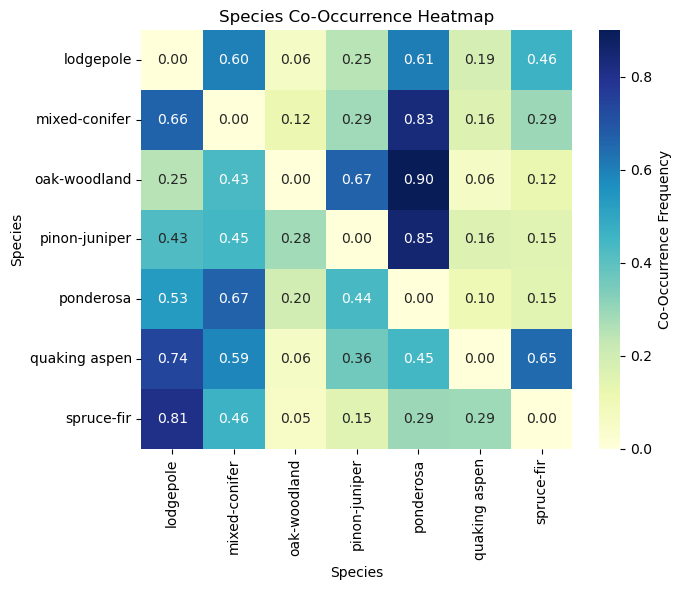

In [37]:
# Species co-occurrence plot
# Threshold species presence where dominance/abundance > 1% of total
dt = 0.05 # 5%
# Create a binary presence-absence matrix
pres_abs = (
    grid_tm_frp
    .pivot_table(index='grid_index', columns='species_gp_n', values='sp_dominance_ld', aggfunc='first')
    .fillna(0)
    .applymap(lambda x: 1 if x >= dt else 0)  # Convert to binary
)

# get the species names and matrix
species = pres_abs.columns
coo_mat = pd.DataFrame(0, index=species, columns=species)

# map across species combinations
for sp1, sp2 in combinations(species, 2):
    # Count co-occurrence (grids where both species are present)
    coo = np.sum(pres_abs[sp1] & pres_abs[sp2])
    coo_mat.loc[sp1, sp2] = coo
    coo_mat.loc[sp2, sp1] = coo  # Symmetry

# Optional: Normalize by the total number of grids for each species
species_totals = pres_abs.sum(axis=0)
norm_mat = coo_mat.div(species_totals, axis=0)

# Create a heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(
    norm_mat, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Co-Occurrence Frequency'}
)
plt.title("Species Co-Occurrence Heatmap")
plt.xlabel("Species")
plt.ylabel("Species")
plt.tight_layout()

out_png = os.path.join(projdir, 'figures/FigureX_Species_CoOccurrence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [40]:
grid_tm_frp.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'species_gp_n', 'tmid_n', 'forest_pct', 'shannon_h', 'balive', 'badead',
       'ba_ld', 'tpa_live', 'tpa_dead', 'tpa_ld', 'tree_ht_live',
       'tree_ht_dead', 'balive_total', 'badead_total', 'ba_ld_total',
       'tpa_live_total', 'tpa_dead_total', 'tpa_ld_total', 'sp_dominance_l',
       'sp_dominance_d', 'sp_dominance_ld

In [51]:
len(df)

73529

Forest classes: ['conifer' 'quaking aspen']

31271 grids w/ some aspen.

   grid_index forest_phys          ba_ld       tpa_ld  abundance  dominance
0      187795     conifer  241774.638308  3754.012558   1.000000   1.000000
1      187796     conifer  244630.770949  3505.619720   0.935872   0.975506
2      187797     conifer    5044.197628   193.602478   1.000000   1.000000

   grid_index   conifer  aspen  combined  frp_max_day
0      187795  1.000000    0.0  1.000000     8.595289
1      187795  1.000000    0.0  1.000000     8.595289
2      187796  0.975506    0.0  0.975506    17.740537



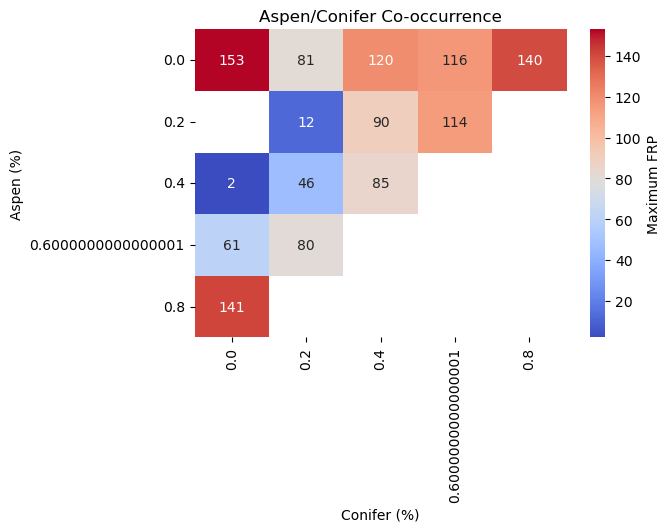

In [54]:
# create a 'conifer' column
df = grid_tm_frp.copy() # work with a copy
df = df[df['frp_max_day'] > 1] # filter out small FRP values

# drop out the oak-woodland group
drop_spp = ['oak-woodland']
df = df[~df['species_gp_n'].isin(drop_spp)]

# label conifer/aspen, summarize percent cover
df['forest_phys'] = df['species_gp_n'].apply(lambda x: 'conifer' if x != 'quaking aspen' else x)
print(f"Forest classes: {df['forest_phys'].unique()}\n")

# aggregate statistics
df = (
    df.groupby(['grid_index', 'forest_phys'], as_index=False)
    .agg(
        ba_ld=('balive','sum'),
        tpa_ld=('tpa_live','sum'),
        abundance=('sp_abundance_ld','sum'),
        dominance=('sp_dominance_ld','sum')
    )
)

# filter to where there is some aspen or conifer
df = df[(df['abundance'] > 0)]

print(f"{len(df[df['forest_phys'] == 'quaking aspen'])} grids w/ some aspen.\n")
print(f"{df.head(3)}\n")

# Pivot to have one row per grid with aspen and conifer as columns
df_p = (
    df.pivot(index='grid_index', columns='forest_phys', values='dominance')
    .fillna(0)  # Fill missing values with 0
    .reset_index()
    .rename(columns={'quaking aspen': 'aspen', 'conifer': 'conifer'})
)

df_p['combined'] = df_p['aspen'] + df_p['conifer']
df_p = df_p[df_p['combined'] > 0.20] # greater than 50% combined dominance

# Add FRP metrics back to the DataFrame
df_p = df_p.merge(
    grid_tm_frp[['grid_index', 'frp_max_day']], on='grid_index', how='left'
)
print(f"{df_p.head(3)}\n")

# bin the data and plot the heatmap
bins = np.linspace(0, 1, 6)  # 10% intervals
df_p['aspen_bin'] = pd.cut(df_p['aspen'], bins, labels=bins[:-1])
df_p['conifer_bin'] = pd.cut(df_p['conifer'], bins, labels=bins[:-1])

# create the summarized data by bins (heatmap)
heatmap_da = df_p.groupby(['aspen_bin', 'conifer_bin']).frp_max_day.mean().unstack()
heatmap_da = heatmap_da.replace(0, np.nan)

# heatmap_da_log = np.log10(heatmap_da + 1e-6)

# plot it
plt.figure(figsize=(6, 4))

sns.heatmap(
    heatmap_da, 
    cmap='coolwarm', 
    annot=True, 
    fmt=".0f", 
    cbar_kws={'label': 'Maximum FRP'}
)

plt.title("Aspen/Conifer Co-occurrence", size=12, loc='center')
plt.xlabel('Conifer (%)')
plt.ylabel('Aspen (%)')

out_plot = os.path.join(projdir, 'figures/FigureX_ConiferAspen_Heatmap_FRPmax_Tree.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# scaled tile version
# conifer/aspen
df = grid_forest.copy() # work with a copy

# label conifer/aspen, summarize percent cover
df['ForestPhys'] = df['SpeciesName'].apply(lambda x: 'Conifer' if x != 'Aspen' else x)
print(f" Forest classes: {df['ForestPhys'].unique()}\n")

# Recalculate percent cover
cover_df = (
    df.groupby(['grid_index', 'ForestPhys'])['spp_pct']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'Aspen': 'aspen_pct', 'Conifer': 'conifer_pct'})
)

cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df['conifer_pct']
# cover_df = cover_df[cover_df['combined_pct'] > 60]

# Merge with FRP data
frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_max_day', 
                     'frp_max_night', 'frp_csum', 'frp_p90']].drop_duplicates()
cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

# Bin Aspen and species percent cover
bins = np.linspace(0, 100, 11)  # 10% intervals
cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=bins[:-1])
cover_df['conifer_bin'] = pd.cut(cover_df['conifer_pct'], bins, labels=bins[:-1])

# Group by bins and calculate statistics
grouped = cover_df.groupby(['aspen_bin', 'conifer_bin'])
counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

# Merge statistics into a single DataFrame
tiles_df = pd.merge(counts, mean_frp, on=['aspen_bin', 'conifer_bin'])
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2

# create the plot
tiles_df['aspen_bin_idx'] = tiles_df['aspen_bin'].cat.codes
tiles_df['conifer_bin_idx'] = tiles_df['conifer_bin'].cat.codes

# get the KDE plot for aspen/conifer
kde_data = cover_df.melt(
    id_vars='grid_index', 
    value_vars=['aspen_pct', 'conifer_pct'], 
    var_name='species', 
    value_name='pct_cover'
)

# Rename for consistent labeling
kde_data['species'] = kde_data['species'].replace({
    'aspen_pct': 'Aspen', 
    'conifer_pct': 'Conifer'
})

In [ ]:
# 1. Prepare the data
# Filter data to remove non-forested or low-FRP grid cells
grid_tm_frp_nonzero = grid_tm_frp[grid_tm_frp['frp_max_day'] > 0]

# Compute the dominant species based on abundance and dominance
dominant_abundance = (
    grid_tm_frp_nonzero.loc[grid_tm_frp_nonzero.groupby('grid_index')['sp_abundance_ld'].idxmax()]
)
dominant_dominance = (
    grid_tm_frp_nonzero.loc[grid_tm_frp_nonzero.groupby('grid_index')['sp_dominance_ld'].idxmax()]
)

# Subset only rows with a significant contribution (threshold adjustable)
abundance_threshold = 0.5  # Example: At least 80% abundance
dominance_threshold = 0.5  # Example: At least 80% dominance

dom_abundance = dominant_abundance[dominant_abundance['sp_abundance_ld'] > abundance_threshold]
dom_dominance = dominant_dominance[dominant_dominance['sp_dominance_ld'] > dominance_threshold]

# Get sorted species order by FRP median
abundance_median = dom_abundance.groupby('species_gp_n')['frp_max_day'].median().sort_values(ascending=False)
dominance_median = dom_dominance.groupby('species_gp_n')['frp_max_day'].median().sort_values(ascending=False)

# Sort species names by FRP medians
abundance_sorted = abundance_median.index.tolist()
dominance_sorted = dominance_median.index.tolist()

# 2. Plot: Abundance-Based
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=dom_abundance,
    x='frp_max_day',
    y='species_gp_n',
    order=abundance_sorted,
    palette='coolwarm_r',
    fliersize=4,
    dodge=False
)
plt.xscale('log')  # Log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type (Abundance-Based)')
plt.title('FRP by Dominant Species (Abundance)')
plt.tight_layout()

# out_plot_abundance = os.path.join(projdir, 'figures/FigureX_ForestAbundance_FRPmax.png')
# plt.savefig(out_plot_abundance, dpi=300, bbox_inches='tight')
# print(f"\nSaved to: {out_plot_abundance}\n")

plt.show()

# 3. Plot: Dominance-Based
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=dom_dominance,
    x='frp_max_day',
    y='species_gp_n',
    order=dominance_sorted,
    palette='coolwarm_r',
    fliersize=4,
    dodge=False
)
plt.xscale('log')  # Log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type (Dominance-Based)')
plt.title('FRP by Dominant Species (Dominance)')
plt.tight_layout()

# out_plot_dominance = os.path.join(projdir, 'figures/FigureX_ForestDominance_FRPmax.png')
# plt.savefig(out_plot_dominance, dpi=300, bbox_inches='tight')
# print(f"\nSaved to: {out_plot_dominance}\n")

plt.show()

In [ ]:
# # Plot the influence of aspen composition on FRP
# # Conifer/Aspen dominance waffle chart

# # create bins for species composition
# bins = np.linspace(0, 100, 6) # 20% intervals
# spps = [s for s in grid_tm_frp['species_gp_n'].unique() if s != 'quaking aspen'] # exclude aspen from species list
# print(f"Associate forest type: {spps}\n")

# df = grid_tm_frp.copy() # work on a copy of the data

# # create grid data
# tiles = []  # Store tile data
# for sp in spps:
#     # Filter for co-occurrence
#     df_sp = df[df['species_gp_n'].isin(['Aspen', sp])]

#     # Pivot to create columns for Aspen and the species
#     cover_df = (
#         df_sp.pivot_table(index='grid_index', columns='species_gp_n', values='spp_pct', fill_value=0)
#         .reset_index()
#         .rename(columns={'Aspen': 'aspen_pct', sp: f'{sp}_pct'})
#     )

#     # make sure there is some of each kind
#     cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df[f'{sp}_pct']
#     cover_df = cover_df[cover_df['combined_pct'] > 50]

#     # Merge with FRP data
#     frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_max_day', 'frp_max_night', 'frp_csum', 'frp_p90']].drop_duplicates()
#     cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

#     # Bin Aspen and species percent cover
#     cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=range(len(bins) - 1))
#     cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_pct'], bins, labels=range(len(bins) - 1))

#     # Group by bins and calculate statistics
#     grouped = cover_df.groupby(['aspen_bin', f'{sp}_bin'])
#     counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
#     mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

#     # Merge statistics into a single DataFrame
#     tiled_data = pd.merge(counts, mean_frp, on=['aspen_bin', f'{sp}_bin'])
#     tiled_data['species'] = sp
#     tiles.append(tiled_data)

# # Combine tile data
# tiles_df = pd.concat(tiles, ignore_index=True)
# tiles_df['log_frp'] = np.log10(tiles_df['frp'] + 1)

# # Normalize tile sizes (scale frequency)
# tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2  # Square root scaling for better size balance

# # Plotting the tile-scaled heatmap
# n_cols = 3  # Number of columns in the facet grid
# n_rows = int(np.ceil(len(spps) / n_cols))
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,3.5), constrained_layout=True)
# axes = axes.flatten()

# vmin = tiles_df['log_frp'].min()
# vmax = tiles_df['log_frp'].quantile()
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Define color normalization based on raw FRP range

# log_frp_min = np.percentile(tiles_df['log_frp'], 10)
# log_frp_max = np.percentile(tiles_df['log_frp'], 90)

# # make the grids
# for i, sp in enumerate(spps):
#     sp_data = tiles_df[tiles_df['species'] == sp]
#     ax = axes[i]

#     vmin = sp_data['frp'].min()
#     vmax = sp_data['frp'].max()

#     for _, row in sp_data.iterrows():
#         x = int(row[f'{sp}_bin'])  
#         y = int(row['aspen_bin'])  
#         size = row['tile_size'] * 0.9
        
#         norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
#         color = plt.cm.coolwarm(norm(row['frp']))
        
#         ax.add_patch(
#             plt.Rectangle(
#                 (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
#             )
#         )

#     # Formatting the axes
#     # ax.set_title(sp, size=10)
#     ax.text(
#         0.95, 0.95, sp,  # x, y position in axis coordinates (top-right corner)
#         transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
#         ha='right', va='top',  # Align the text to the top-right
#         fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
#     )
#     ax.set_xlabel(f'')
#     ax.set_ylabel('Aspen Cover (%)', size=9)
#     ax.set_xticks(range(len(bins) - 1))
#     ax.set_yticks(range(len(bins) - 1))
#     ax.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
#     ax.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
#     ax.set_xlim(-0.5, len(bins) - 1.5)
#     ax.set_ylim(-0.5, len(bins) - 1.5)

#     # sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
#     # cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.50, pad=0.1)
#     # cbar.set_label('Maximum FRP')

# sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
# cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
# cbar.set_label('Maximum FRP')
# cbar.set_label('Cumulative FRP', fontsize=10)
# cbar.ax.tick_params(labelsize=8)

# # Remove unused axes
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# del df

# out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_FRPmax_Scaled.png')
# plt.savefig(out_plot, dpi=300, bbox_inches='tight')

# plt.show()